In [23]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [24]:
def objective(x):
    y1 = torch.sin(x * (2 * math.pi)) + torch.randn(1)
    y2 = torch.cos(x * (2 * math.pi)) + torch.randn(1)

    return torch.Tensor([y1, y2])

In [25]:
train_x = torch.linspace(0, 1, 100)[torch.randint(0, 100, (10,))]
train_y, train_y_std = [], []
num_draws = 25
for x in train_x:
    y = []
    for _ in range(num_draws):
        y.append(objective(x))
    train_y.append(torch.stack(y).mean(dim=0))
    train_y_std.append(torch.stack(y).std(dim=0))
train_y_std = torch.stack(train_y_std)
train_y = torch.stack(train_y)

The following allows us to specify a prior on the noise which we estimate based on the noisy samples obtained from evaluating the function above. 

The noise mean is zero because the we specify the mean value of the noisy evaluation to be our `train_y` and we take the maximum covariance (std) observed above to specify the noise covariance prior.

We would let these parameters to be optimized since we only know these values on few samples and let the model learn values that are sutiable across our `test_x`

In [26]:
noise_mean = torch.zeros(2)
noise_covar = torch.eye(2)*train_y_std.max(dim=0).values
noise_prior = gpytorch.priors.MultivariateNormalPrior(loc=noise_mean, 
                                                      covariance_matrix=noise_covar)

In [27]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, noise_prior=noise_prior)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [28]:
training_iterations = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if i%10==0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))


Iter 1/100 - Loss: 1.619
Iter 11/100 - Loss: 1.286
Iter 21/100 - Loss: 1.010
Iter 31/100 - Loss: 0.808
Iter 41/100 - Loss: 0.712
Iter 51/100 - Loss: 0.701
Iter 61/100 - Loss: 0.701
Iter 71/100 - Loss: 0.696
Iter 81/100 - Loss: 0.696
Iter 91/100 - Loss: 0.696


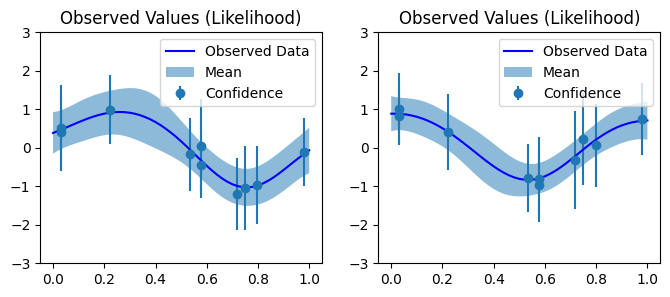

In [29]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.errorbar(train_x.detach().numpy(), 
               train_y[:, 0].detach().numpy(), 
               yerr=train_y_std[:,0].detach().numpy(),
               marker='o',
               linestyle='none'
               )
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.errorbar(train_x.detach().numpy(), 
               train_y[:, 1].detach().numpy(), 
               yerr=train_y_std[:,1].detach().numpy(),
               marker='o',
               linestyle='none'
               )
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')
plt.show()